# Image classification

Image classification assigns a class label to an image. Unlike text or audio classification, the inputs are the
pixel values that comprise an image. There are many applications for image classification. This notebook illustrates how to:

1. Fine-tune a [Data-efficient image Transformers (DeiT)](https://huggingface.co/docs/transformers/en/model_doc/deit) on the [CIFAR10](https://huggingface.co/datasets/cifar10) dataset.

2. Use your fine-tuned model for inference.



In [1]:
!pip install transformers transformers[torch] datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00


## Load CIFAR10 dataset

Start by loading the CIFAR10 dataset from the Datasets library.

In [2]:
from datasets import load_dataset

cifar = load_dataset("cifar10")
cifar

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [3]:
cifar["train"].features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

In this example, the [train_test_split function](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.train_test_split) is used to define a small training and validation set for the purpose of illustrating the fine-tuning process.

In [4]:
splits = cifar["train"].shuffle().train_test_split(test_size=0.001, train_size=0.02, seed=13)
print(splits)

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 50
    })
})


In [5]:
tr_cifar = splits['train']
dv_cifar = splits['test']
te_cifar = cifar['test'].shuffle()

Then, take a look at the first example in the training set:

In [6]:
tr_cifar[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 7}

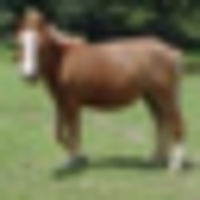

In [7]:
tr_cifar[0]["img"].resize((200, 200))

Each example in the dataset has two fields:

- `image`: a PIL image of the cifar item
- `label`: the label class of the cifar item

To make it easier for the model to get the label name from the label id, create a dictionary that maps the label name
to an integer and vice versa:

In [8]:
labels = tr_cifar.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

Now you can convert the label id to a label name:

In [9]:
id2label[tr_cifar[0]["label"]]

'horse'

## Preprocess

Before we can feed these images to our model, we need to preprocess them.

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html) for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), [Kornia](https://kornia.readthedocs.io/en/latest/) etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the [AutoFeatureExtractor.from_pretrained function](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoFeatureExtractor).

This feature extractor is a minimal preprocessor that can be used to prepare images for inference.

In [10]:
from transformers import AutoFeatureExtractor

checkpoint = "facebook/deit-tiny-patch16-224"
feature_extractor = AutoFeatureExtractor.from_pretrained(checkpoint)
feature_extractor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using [`.map()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) or [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing).

In [11]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size['height'],feature_extractor.size['width'])),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

dev_transforms = Compose(
        [
            Resize((feature_extractor.size['height'],feature_extractor.size['width'])),
            CenterCrop((feature_extractor.size['height'],feature_extractor.size['width'])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["img"]
    ]
    return example_batch

def preprocess_dev(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [dev_transforms(image.convert("RGB")) for image in example_batch["img"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use the set_transform functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [12]:
tr_cifar.set_transform(preprocess_train)
dv_cifar.set_transform(preprocess_dev)

Let's access an element to see that we've added a "pixel_values" feature:

In [13]:
tr_cifar[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 7,
 'pixel_values': tensor([[[-0.6078, -0.6078, -0.6078,  ..., -0.7569, -0.7569, -0.7569],
          [-0.6078, -0.6078, -0.6078,  ..., -0.7569, -0.7569, -0.7569],
          [-0.6078, -0.6078, -0.6078,  ..., -0.7569, -0.7569, -0.7569],
          ...,
          [ 0.1608,  0.1608,  0.1608,  ...,  0.2000,  0.2000,  0.2000],
          [ 0.1608,  0.1608,  0.1608,  ...,  0.2000,  0.2000,  0.2000],
          [ 0.1608,  0.1608,  0.1608,  ...,  0.2000,  0.2000,  0.2000]],
 
         [[-0.7176, -0.7176, -0.7176,  ..., -0.6706, -0.6706, -0.6706],
          [-0.7176, -0.7176, -0.7176,  ..., -0.6706, -0.6706, -0.6706],
          [-0.7176, -0.7176, -0.7176,  ..., -0.6706, -0.6706, -0.6706],
          ...,
          [ 0.2471,  0.2471,  0.2471,  ...,  0.2314,  0.2314,  0.2314],
          [ 0.2471,  0.2471,  0.2471,  ...,  0.2314,  0.2314,  0.2314],
          [ 0.2471,  0.2471,  0.2471,  ...,  0.2314,  0.2314,  0.2314]],
 
  

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the [AutoModelForImageClassification class](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification). Calling the [from_pretrained function](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification.from_pretrained) on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. In this case, we also need to provide the additional argument `ignore_mismatched_sizes=True` to the `from_pretrained` method. This will make sure the output head with 1000 output neurons is thrown away and replaced by a new, randomly initialized classification head with 10 output neurons for our image classification task.

In [14]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True,
)


pytorch_model.bin:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [15]:
model_name = checkpoint.split("/")[-1]
batch_size = 32 # batch size for training and evaluation

args = TrainingArguments(
    f"{model_name}-finetuned-cifar",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

We need to define the accuracy metric, which we will use to evaluate our model both during and after training.

In [16]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-16-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [17]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a data collator `collate_fn` function, which will be used to batch examples together. Images as tensors will be stacked/batched over rows using [torch.stack](https://pytorch.org/docs/stable/generated/torch.stack.html), while labels are converted into a tensor of labels.  Each batch consists of two keys, namely `pixel_values` and `labels`.

In [18]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [19]:
trainer = Trainer(
    model,
    args,
    train_dataset=tr_cifar,
    eval_dataset=dv_cifar,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Now we can finetune our model by calling the `train` method:

In [20]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.005863,0.260000
2,2.194800,1.835493,0.320000
3,1.884400,1.722190,0.400000


***** train metrics *****
  epoch                    =        3.0
  total_flos               = 13945304GF
  train_loss               =     1.9909
  train_runtime            = 0:00:25.11
  train_samples_per_second =    119.435
  train_steps_per_second   =      0.955


## Inference

Let's take a subset from the test set to classify it using the fine-tuned model. We apply the same preprocessing applied to the dev set.

In [21]:
te_batch_encoded = [dev_transforms(example.convert("RGB")) for example in te_cifar[:10]["img"]]
te_batch_stacked = torch.stack(te_batch_encoded)
encoding = te_batch_stacked
print(te_batch_stacked.shape)

torch.Size([10, 3, 224, 224])


Actual inference on test samples using the fine-tuned model:

In [22]:
outputs = model(encoding.cuda())
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([10, 10])


Computing argmax to perform classification:

In [23]:
predicted_class_idx = logits.argmax(-1).numpy()
print("Predicted class:", [model.config.id2label[idx] for idx in predicted_class_idx])

Predicted class: ['horse', 'automobile', 'horse', 'cat', 'truck', 'bird', 'airplane', 'cat', 'airplane', 'dog']


In [24]:
actual_class_idx = te_cifar[:10]["label"]
print("Actual class:", [model.config.id2label[idx] for idx in actual_class_idx])

Actual class: ['cat', 'airplane', 'deer', 'cat', 'truck', 'deer', 'bird', 'horse', 'airplane', 'frog']


Computing accuracy comparing predicted to actual class labels:

In [25]:
metric.compute(predictions=predicted_class_idx, references=actual_class_idx)

{'accuracy': 0.3}